<br>Model from:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

-----------------------------------------
# Data visualization

In [1]:
import sys
sys.executable

'/Users/yevhenp/anaconda3/envs/keras-env/bin/python'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.nasnet import NASNetMobile
# from keras.applications import NASNetMobile
# from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average
from keras.layers import Input, Concatenate, GlobalMaxPooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras import utils as np_utils
from livelossplot import PlotLossesKeras
import tensorflow as tf

import cv2

sys.path.insert(0, '../')
from src.dataGenerator import *

# import src.constants

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[]

In [4]:
# %load_ext tensorboard.notebook


In [11]:
# Output files
OUTPUT_DIR = "output_model2_2_tensorboard_lr/"
!mkdir {OUTPUT_DIR}

OUTPUT_TENSORBOARD_DIR = OUTPUT_DIR+"/logs/"
# !mkdir output_model2_2/logs/
# !tensorboard --logdir=output_model2_2/logs/

# MODEL_SUMMARY_FILE = OUTPUT_DIR + "model_summary.txt"
MODEL_PLOT_FILE = OUTPUT_DIR + "model_plot.png"

# Path to images
DATA_DIR = "../data"

TRAINING_LOGS_FILE_2 = OUTPUT_DIR + "training_logs_aug.csv"
MODEL_FILE_2 = OUTPUT_DIR + "model_aug.h5"
TRAINING_PLOT_FILE_2 = OUTPUT_DIR + "training_aug.png"
VALIDATION_PLOT_FILE_2 = OUTPUT_DIR + "validation_aug.png"
ROC_PLOT_FILE_2 = OUTPUT_DIR + "roc_aug.png"

KAGGLE_SUBMISSION_FILE_2 = OUTPUT_DIR + "kaggle_submission_aug.csv"

# Hyperparams
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 13
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

mkdir: output_model2_2_tensorboard_lr/: File exists


In [12]:
data = pd.read_csv(DATA_DIR + '/train_labels.csv')
print(data['label'].value_counts())
training_data, validation_data = train_test_split(data, train_size=TRAINING_RATIO, stratify=data['label'])
print(training_data['label'].value_counts())
print(validation_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64
0    117817
1     80205
Name: label, dtype: int64
0    13091
1     8912
Name: label, dtype: int64


/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': True}

training_generator_with_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_with_aug = DataGenerator(validation_data.id, validation_data.label, **params)

Data augmentation enabled
Data augmentation enabled


In [32]:
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from time import time
import math

# Model
def create_model(file = ''):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = "sigmoid"))
    
    if (os.path.exists(file) == True):
        print("Load model from file: ", file)
        model = load_model(file)

    # Compile the model
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    model.summary()

    plot_model(model,
               to_file=MODEL_PLOT_FILE,
               show_shapes=True,
               show_layer_names=True)
    
    return model

def train(model, training_generator, validation_generator, model_file, logs_file):

    tensorboard = TensorBoard(log_dir=OUTPUT_TENSORBOARD_DIR+"/{}".format(time()))
    # learning rate schedule
    def step_decay(epoch):
        initial_lrate = 0.001 # Adam optimizer
        # drop it on 0.1 every two epochs         
        drop = 0.1 
        epochs_drop = 2.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        print("epoch: %d, learning rate = %.4f" % (epoch, lrate))
        return lrate
    
    lr_sched = LearningRateScheduler(step_decay)

    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=EPOCHS,
                            callbacks=[PlotLossesKeras(),
                                        ModelCheckpoint(model_file,
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),
                                         CSVLogger(logs_file,
                                                   append=False,
                                                   separator=';'),
                                         tensorboard,
                                         lr_sched])

In [33]:
model_with_aug = create_model(MODEL_FILE_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_43 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_43 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 44, 44, 64)        18432     
__________

In [ ]:
history = train(model = model_with_aug, 
            training_generator = training_generator_with_aug,
            validation_generator = validation_generator_with_aug,
            model_file = MODEL_FILE_2,
            logs_file = TRAINING_LOGS_FILE_2)

Epoch 1/13
epoch: 0, learning rate = 0.0010
   1/1031 [..............................] - ETA: 6:45:15 - loss: 1.1055 - acc: 0.4010

Process ForkPoolWorker-88:
Process ForkPoolWorker-93:
Process ForkPoolWorker-95:
Process ForkPoolWorker-86:
Process ForkPoolWorker-90:
Process ForkPoolWorker-94:
Process ForkPoolWorker-87:
Process ForkPoolWorker-85:
Process ForkPoolWorker-96:
Process ForkPoolWorker-92:
Process ForkPoolWorker-89:
Process ForkPoolWorker-91:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.ru

  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/Users/yevhenp/anaconda3/envs/keras-env/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "

In [ ]:
def plot_epochs(history, training_plot_file, validation_plot_file):
    # Training plots
    epochs = [i for i in range(1, len(history.history['loss'])+1)]

    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('training')
    plt.xlabel('epoch')
    plt.savefig(training_plot_file, bbox_inches='tight')
    plt.close()

    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('validation')
    plt.xlabel('epoch')
    plt.savefig(validation_plot_file, bbox_inches='tight')
    plt.close()

In [15]:
def plot_AUC(model, testing_generator, model_file, plot_file):
    # ROC testing plot
#     model.load_weights(model_file)
    predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
#     print(len(testing_generator))
#     print(testing_generator.classes.shape)
#     print(predictions.shape)
#     print(predictions)
    false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    
    print("False positive: ", false_positive_rate)
    print("True positive: ", true_positive_rate)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()


In [16]:
def test(model, file):
    testing_files = glob(os.path.join('data/test/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        data_frame['label'] = predictions
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(file, index=False, header=True)

In [17]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False,
          'augmentation': False}

testing_generator = DataGenerator(validation_data.id, validation_data.label, **params)
# plot_epochs(history, TRAINING_PLOT_FILE_1, VALIDATION_PLOT_FILE_1)

114/114 [==============================] - 11s 99ms/step
False positive:  [0. 1.]
True positive:  [0. 1.]


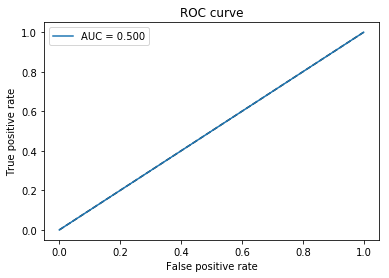

FileNotFoundError: [Errno 2] No such file or directory: 'output_model2_2/roc_aug.png'

<Figure size 432x288 with 0 Axes>

In [18]:
plot_AUC(model_with_aug, testing_generator, MODEL_FILE_2, ROC_PLOT_FILE_2)

In [2]:
# %load_ext tensorboard.notebook
# # os.makedirs(OUTPUT_TENSORBOARD_DIR, exist_ok=True)

# %tensorboard --logdir {OUTPUT_TENSORBOARD_DIR}


Launching TensorBoard...

In [19]:
test(model = model_with_aug, file = KAGGLE_SUBMISSION_FILE_2)

FileNotFoundError: [Errno 2] No such file or directory: 'output_model2_2/kaggle_submission_aug.csv'